In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [3]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

test = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=False,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


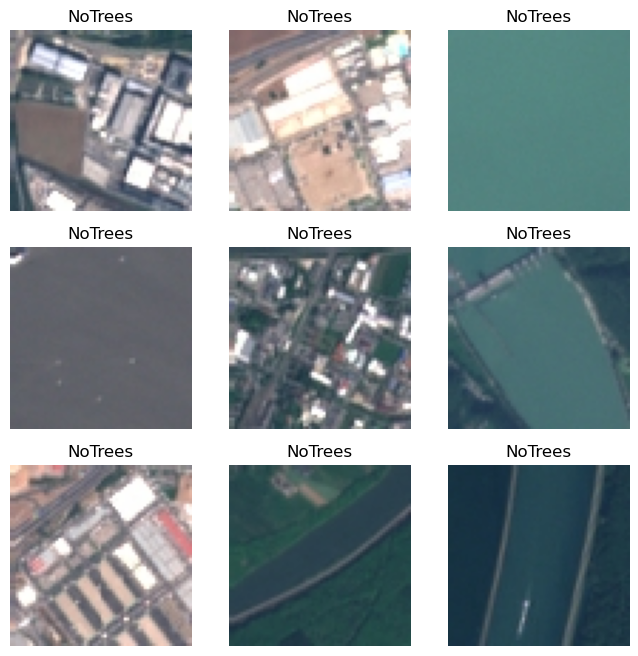

In [4]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [54]:
# build a network from scratch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model_1 = Sequential(name="model_1")
model_1.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_1.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid')) #1 for binary output


In [6]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0

In [8]:
from time import time

In [52]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

history_model_1 = model_1.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 32s 62ms/step - loss: 0.0764 - accuracy: 0.9683 - val_loss: 1.0204 - val_accuracy: 0.6660
Epoch 2/20
517/517 [==============================] - 36s 69ms/step - loss: 0.0685 - accuracy: 0.9730 - val_loss: 0.0327 - val_accuracy: 0.9923
Epoch 3/20
517/517 [==============================] - 38s 74ms/step - loss: 0.0893 - accuracy: 0.9682 - val_loss: 0.0551 - val_accuracy: 0.9860
Epoch 4/20
517/517 [==============================] - 42s 81ms/step - loss: 0.0525 - accuracy: 0.9806 - val_loss: 3.4778 - val_accuracy: 0.4245
Epoch 5/20
517/517 [==============================] - 39s 75ms/step - loss: 0.0535 - accuracy: 0.9798 - val_loss: 0.0655 - val_accuracy: 0.9773
Elapsed Time = 187.4127712249756 seconds


Now that I have a proper model run, I'll make a function to plot the learning curves:

In [10]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

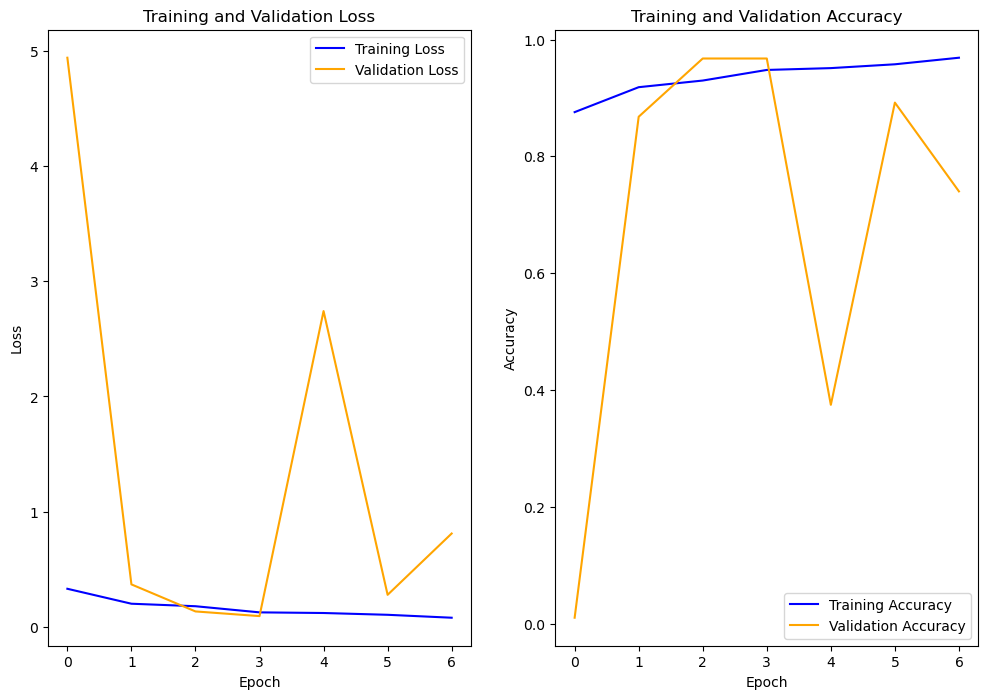

In [11]:
model_1_plots = plot_learning_curve(history)

So, it looks like improvements in the training accuracy and loss start to level off after around 10-12 epochs. The validation loss and accuracy bounce around but then appear to get worse after the 13th epoch. I will try out a slower learning rate to see if that reduces the noise in the validation learning curves and introduce early stopping:

In [55]:
#model 2
model_2 = Sequential(name="model_2")
model_2.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [13]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)
#lr_reducer = tf.keras.callbacks.LearningRateScheduler(scheduler)

start = time()

# Fit the model
history_model_2 = model_2.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 33s 62ms/step - loss: 0.3114 - accuracy: 0.8811 - val_loss: 3.4212 - val_accuracy: 0.0315
Epoch 2/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1839 - accuracy: 0.9267 - val_loss: 1.0544 - val_accuracy: 0.5581
Epoch 3/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1515 - accuracy: 0.9394 - val_loss: 0.1997 - val_accuracy: 0.9264
Epoch 4/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1280 - accuracy: 0.9526 - val_loss: 0.0413 - val_accuracy: 0.9845
Epoch 5/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1040 - accuracy: 0.9607 - val_loss: 0.0746 - val_accuracy: 0.9748
Epoch 6/20
517/517 [==============================] - 32s 62ms/step - loss: 0.0939 - accuracy: 0.9641 - val_loss: 0.1672 - val_accuracy: 0.9448
Epoch 7/20
517/517 [==============================] - 34s 65ms/step - loss: 0.0767 - accuracy: 0.9717 - val_loss: 0.1814 - val_accuracy:

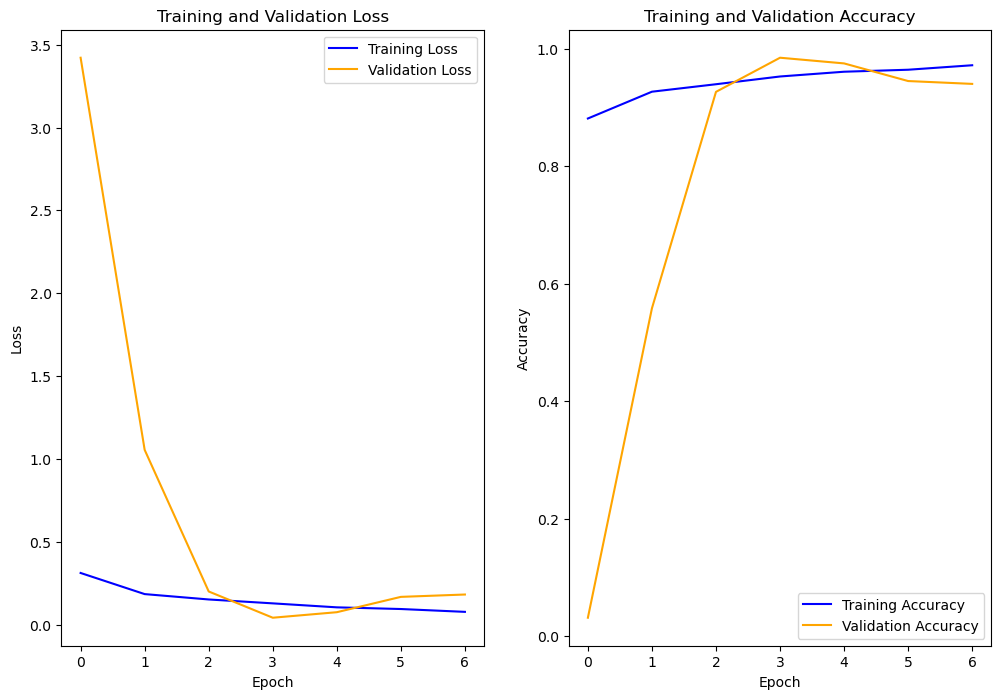

In [16]:
model_2_plots = plot_learning_curve(history_model_2)

Reducing the learning rate got rid of a lot of the jumpiness in the validation learning curves. And with the early stopping callback parameter validation accuracy hit a peak on the 3rd epoch and did not improve past that mark after three more epochs and so training stopped. 
The next network below will add more neurons to the convolutional and dense layers

In [58]:
#let's try the same model architecture as model_2 but with a slightly slower learning rate
model_2a = Sequential(name="model_2a")
model_2a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2a.add(MaxPool2D())
model_2a.add(BatchNormalization())
model_2a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2a.add(MaxPool2D())
model_2a.add(BatchNormalization())
model_2a.add(Flatten())
model_2a.add(Dense(64, activation='relu'))
model_2a.add(Dense(1, activation='sigmoid'))

model_2a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
start = time()

# Fit the model
history_model_2a = model_2a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 55s 104ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.0239 - val_accuracy: 0.9908
Epoch 2/20
517/517 [==============================] - 32s 61ms/step - loss: 0.0633 - accuracy: 0.9762 - val_loss: 0.2345 - val_accuracy: 0.9085
Epoch 3/20
517/517 [==============================] - 32s 61ms/step - loss: 0.0541 - accuracy: 0.9810 - val_loss: 0.3698 - val_accuracy: 0.8727
Epoch 4/20
517/517 [==============================] - 32s 62ms/step - loss: 0.0636 - accuracy: 0.9757 - val_loss: 0.1503 - val_accuracy: 0.9366
Elapsed Time = 150.51168060302734 seconds


In [56]:
#model 3
model_3 = Sequential(name="model_3")
model_3.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_3.add(Conv2D(24, kernel_size=3, padding='same', activation = 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Conv2D(48, kernel_size=3, padding='same', activation= 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(96, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_23 (Bat  (None, 32, 32, 24)       96        
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 48)       0   

In [23]:
start = time()

# Fit the model
history_model_3 = model_3.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 44s 82ms/step - loss: 0.4238 - accuracy: 0.8587 - val_loss: 1.7115 - val_accuracy: 0.2149
Epoch 2/20
517/517 [==============================] - 44s 85ms/step - loss: 0.1874 - accuracy: 0.9241 - val_loss: 0.2542 - val_accuracy: 0.8959
Epoch 3/20
517/517 [==============================] - 44s 85ms/step - loss: 0.1558 - accuracy: 0.9388 - val_loss: 0.1148 - val_accuracy: 0.9710
Epoch 4/20
517/517 [==============================] - 44s 84ms/step - loss: 0.1318 - accuracy: 0.9491 - val_loss: 0.2362 - val_accuracy: 0.9172
Epoch 5/20
517/517 [==============================] - 44s 85ms/step - loss: 0.1317 - accuracy: 0.9489 - val_loss: 0.1479 - val_accuracy: 0.9487
Epoch 6/20
517/517 [==============================] - 44s 85ms/step - loss: 0.1160 - accuracy: 0.9550 - val_loss: 0.0891 - val_accuracy: 0.9748
Epoch 7/20
517/517 [==============================] - 44s 84ms/step - loss: 0.1005 - accuracy: 0.9613 - val_loss: 0.3029 - val_accuracy:

So with this network with more neurons, validation accuracy and loss are very volatile again, even with the reduced learning rate. 

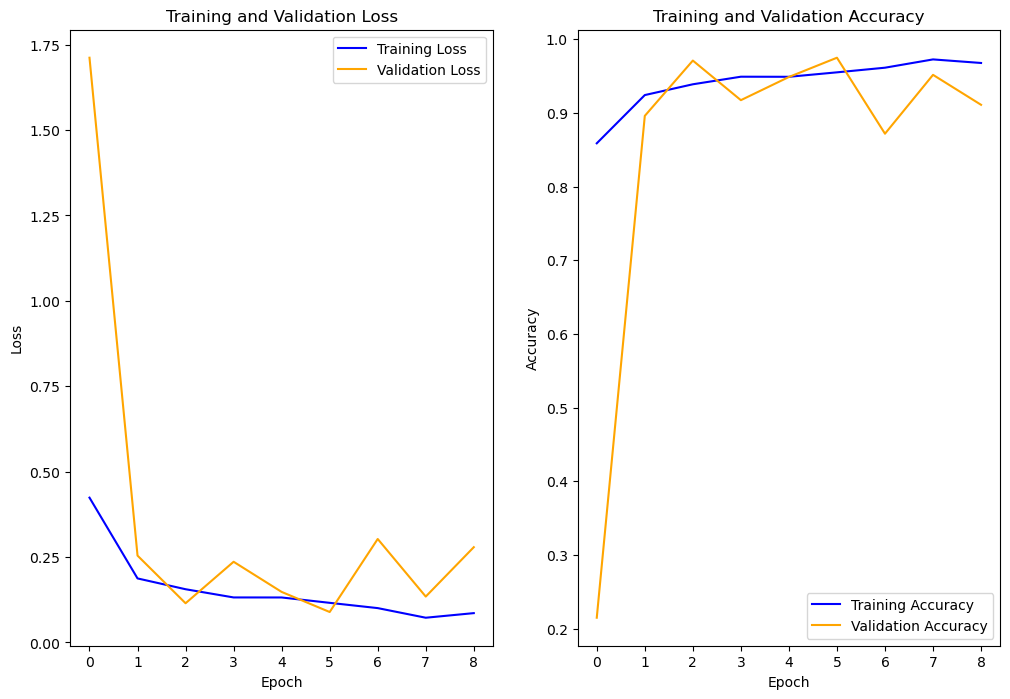

In [24]:
model_3_plots = plot_learning_curve(history_model_3)

I'll now try a model similar to model 2 with the original numebr of neurons, but with sigmoid instead of relu activation functions for the convolutional layers:

In [27]:
#model 4
model_4 = Sequential(name="model_4")
model_4.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Flatten())
model_4.add(Dense(64, activation='sigmoid'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0   

In [28]:
# we'll do early stopping again
start = time()

# Fit the model
history_model_4 = model_4.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 38s 69ms/step - loss: 0.3714 - accuracy: 0.8369 - val_loss: 0.6442 - val_accuracy: 0.6955
Epoch 2/20
517/517 [==============================] - 34s 66ms/step - loss: 0.2697 - accuracy: 0.8914 - val_loss: 0.2321 - val_accuracy: 0.9167
Epoch 3/20
517/517 [==============================] - 34s 66ms/step - loss: 0.2212 - accuracy: 0.9122 - val_loss: 0.4482 - val_accuracy: 0.7570
Epoch 4/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1720 - accuracy: 0.9364 - val_loss: 0.1634 - val_accuracy: 0.9487
Epoch 5/20
517/517 [==============================] - 34s 65ms/step - loss: 0.1271 - accuracy: 0.9539 - val_loss: 0.1248 - val_accuracy: 0.9598
Epoch 6/20
517/517 [==============================] - 35s 68ms/step - loss: 0.1021 - accuracy: 0.9629 - val_loss: 0.0876 - val_accuracy: 0.9773
Epoch 7/20
517/517 [==============================] - 35s 68ms/step - loss: 0.0895 - accuracy: 0.9683 - val_loss: 0.0372 - val_accuracy:

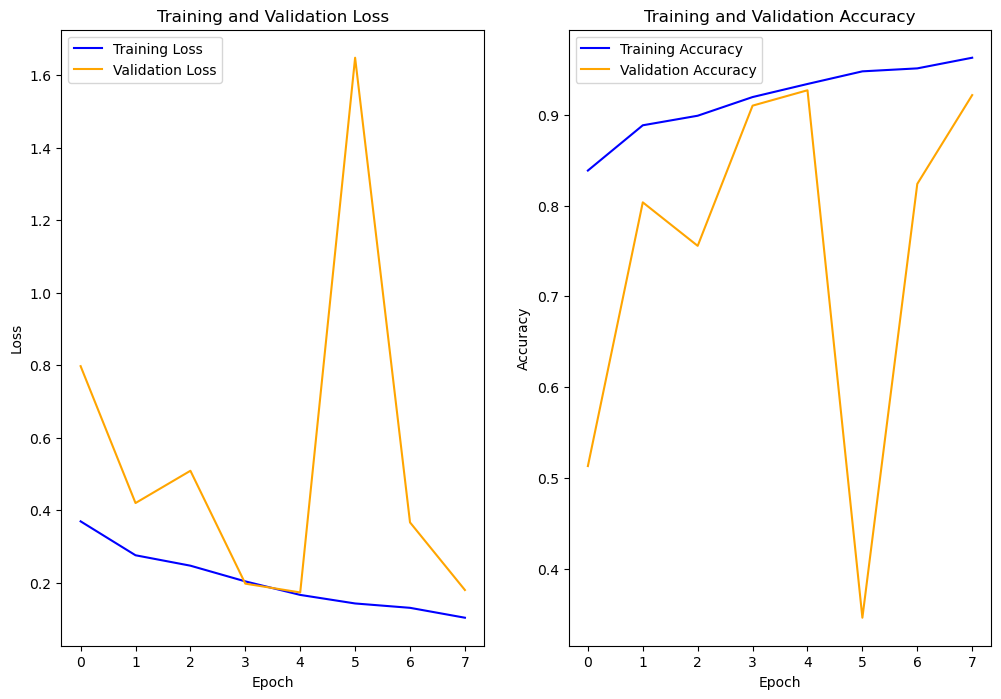

In [47]:
model_4_plots = plot_learning_curve(history_model_4)

With sigmoid activation functions in the convolutional layers, the network hits peak validation accuracy after the 9th epoch and stops early after the 12th when validation accuracy does not improve further.

In [48]:
max(history_model_4.history['val_accuracy'])

0.9269118905067444

In [21]:
max(history_model_3.history['val_accuracy'])

NameError: name 'history_model_3' is not defined

So the network with two convolutional layers and one dense layer all using the relu activation function performed better than the one with sigmoid activation functions. And the validation loss and accuracy are still very volatile even with the reduced learning rate. I could try reducing it further. And after that, I will try an additional convolutional layer, using relu activation again.

In [30]:
model_4a = Sequential(name="model_4a")
model_4a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Flatten())
model_4a.add(Dense(64, activation='sigmoid'))
model_4a.add(Dense(1, activation='sigmoid'))

model_4a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
start = time()

# Fit the model
history_model_4a = model_4a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 34s 64ms/step - loss: 0.3814 - accuracy: 0.8385 - val_loss: 0.3287 - val_accuracy: 0.8533
Epoch 2/20
517/517 [==============================] - 36s 69ms/step - loss: 0.2673 - accuracy: 0.8941 - val_loss: 0.1933 - val_accuracy: 0.9308
Epoch 3/20
517/517 [==============================] - 38s 74ms/step - loss: 0.2259 - accuracy: 0.9110 - val_loss: 0.1957 - val_accuracy: 0.9255
Epoch 4/20
517/517 [==============================] - 35s 67ms/step - loss: 0.1757 - accuracy: 0.9368 - val_loss: 0.0969 - val_accuracy: 0.9724
Epoch 5/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1349 - accuracy: 0.9528 - val_loss: 0.0648 - val_accuracy: 0.9879
Epoch 6/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1217 - accuracy: 0.9587 - val_loss: 0.0457 - val_accuracy: 0.9923
Epoch 7/20
517/517 [==============================] - 34s 66ms/step - loss: 0.0950 - accuracy: 0.9648 - val_loss: 0.8522 - val_accuracy:

In [34]:
#model 5
model_5 = Sequential(name="model_5")
model_5.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 32)       0   

In [35]:
start = time()

# Fit the model
history_model_5 = model_5.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 50s 93ms/step - loss: 0.3216 - accuracy: 0.8662 - val_loss: 0.8731 - val_accuracy: 0.5058
Epoch 2/20
517/517 [==============================] - 48s 93ms/step - loss: 0.1769 - accuracy: 0.9310 - val_loss: 0.2489 - val_accuracy: 0.9037
Epoch 3/20
517/517 [==============================] - 43s 82ms/step - loss: 0.1519 - accuracy: 0.9405 - val_loss: 0.1620 - val_accuracy: 0.9395
Epoch 4/20
517/517 [==============================] - 44s 84ms/step - loss: 0.1326 - accuracy: 0.9450 - val_loss: 0.1098 - val_accuracy: 0.9632
Epoch 5/20
517/517 [==============================] - 46s 90ms/step - loss: 0.1194 - accuracy: 0.9563 - val_loss: 0.1546 - val_accuracy: 0.9463
Epoch 6/20
517/517 [==============================] - 46s 89ms/step - loss: 0.1056 - accuracy: 0.9601 - val_loss: 1.2971 - val_accuracy: 0.5242
Epoch 7/20
517/517 [==============================] - 46s 89ms/step - loss: 0.0885 - accuracy: 0.9653 - val_loss: 2.9140 - val_accuracy:

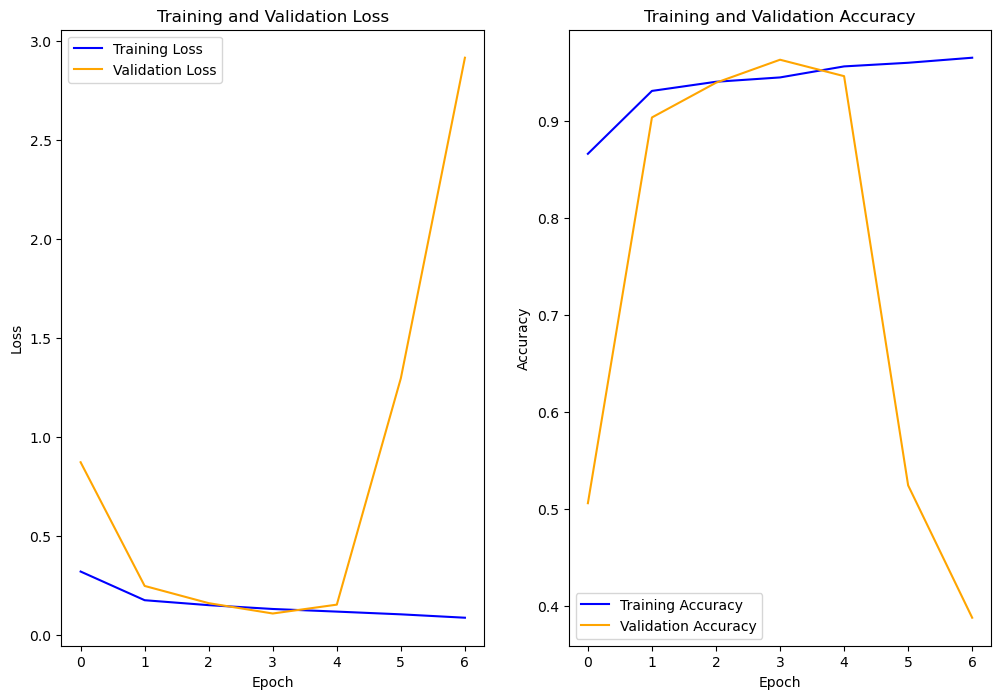

In [36]:
model_5_plots = plot_learning_curve(history_model_5)

I'll try a model similar to 5, but with SGD optimizer instead of adam

In [37]:
#model 5a
model_5a = Sequential(name="model_5a")
model_5a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(Flatten())
model_5a.add(Dense(64, activation='relu'))
model_5a.add(Dense(1, activation='sigmoid'))

model_5a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])


In [38]:
start = time()

# Fit the model
history_model_5a = model_5a.fit(training, validation_data=test, epochs=12)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/12
517/517 [==============================] - 42s 81ms/step - loss: 0.3860 - accuracy: 0.8344 - val_loss: 0.8526 - val_accuracy: 0.3577
Epoch 2/12
517/517 [==============================] - 41s 79ms/step - loss: 0.3038 - accuracy: 0.8743 - val_loss: 0.6517 - val_accuracy: 0.6767
Epoch 3/12
517/517 [==============================] - 39s 76ms/step - loss: 0.2641 - accuracy: 0.8962 - val_loss: 0.5663 - val_accuracy: 0.7323
Epoch 4/12
517/517 [==============================] - 37s 71ms/step - loss: 0.2318 - accuracy: 0.9060 - val_loss: 0.3322 - val_accuracy: 0.8775
Epoch 5/12
517/517 [==============================] - 39s 75ms/step - loss: 0.2092 - accuracy: 0.9156 - val_loss: 0.4615 - val_accuracy: 0.8040
Epoch 6/12
517/517 [==============================] - 36s 70ms/step - loss: 0.2047 - accuracy: 0.9205 - val_loss: 0.2452 - val_accuracy: 0.9167
Epoch 7/12
517/517 [==============================] - 36s 68ms/step - loss: 0.1845 - accuracy: 0.9252 - val_loss: 0.1973 - val_accuracy:

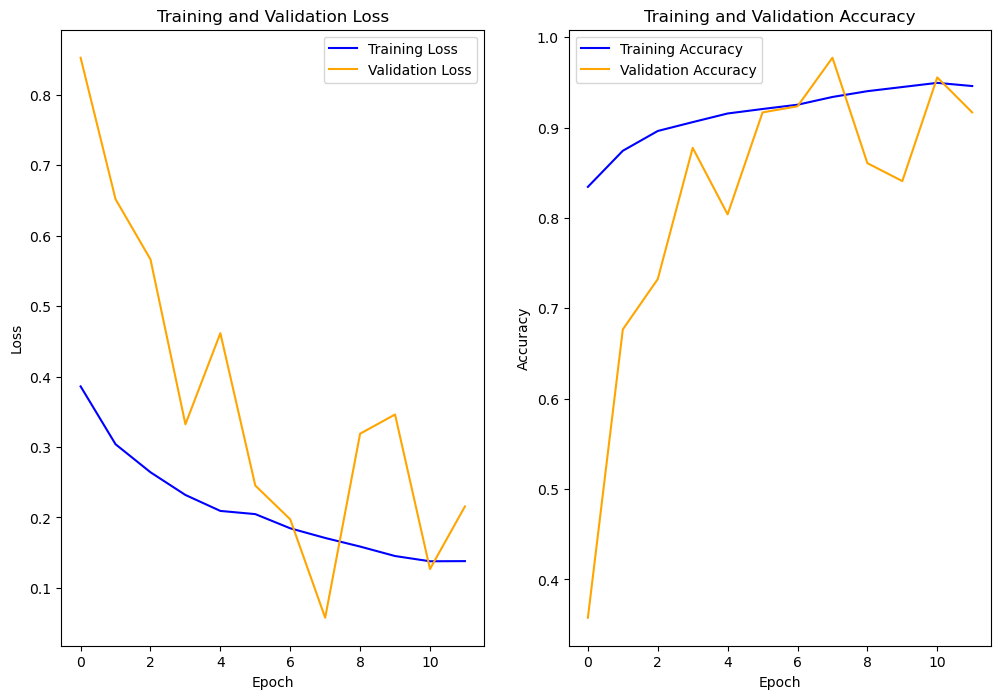

In [39]:
model_5a_plots = plot_learning_curve(history_model_5a)

I also wanted totry out an even simpler model than the first one, with only one convolutional layer:

In [40]:
model_0 = Sequential(name="model_0")
model_0.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0.add(MaxPool2D())
model_0.add(BatchNormalization())
model_0.add(Flatten())
model_0.add(Dense(32, activation='relu'))
model_0.add(Dense(1, activation='sigmoid'))

In [41]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_8 (Flatten)         (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                5243

In [42]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0 = model_0.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 22s 41ms/step - loss: 0.3688 - accuracy: 0.8481 - val_loss: 0.2496 - val_accuracy: 0.9603
Epoch 2/20
517/517 [==============================] - 21s 41ms/step - loss: 0.2739 - accuracy: 0.8843 - val_loss: 0.2313 - val_accuracy: 0.9056
Epoch 3/20
517/517 [==============================] - 24s 46ms/step - loss: 0.2268 - accuracy: 0.9054 - val_loss: 0.2147 - val_accuracy: 0.9114
Epoch 4/20
517/517 [==============================] - 24s 47ms/step - loss: 0.1889 - accuracy: 0.9192 - val_loss: 0.3734 - val_accuracy: 0.9037
Epoch 5/20
517/517 [==============================] - 24s 46ms/step - loss: 0.1674 - accuracy: 0.9285 - val_loss: 0.3493 - val_accuracy: 0.8955
Epoch 6/20
517/517 [==============================] - 22s 43ms/step - loss: 0.1656 - accuracy: 0.9284 - val_loss: 0.9146 - val_accuracy: 0.6936
Elapsed Time = 137.73765540122986 seconds


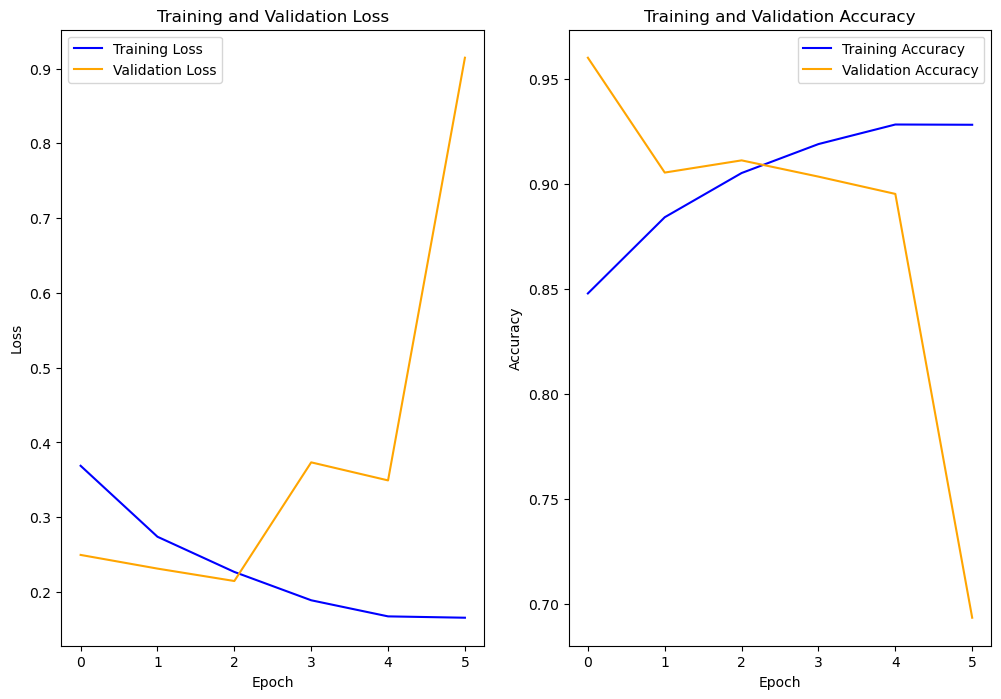

In [43]:
model_0_plots = plot_learning_curve(history_model_0)

Again, very volatile validation learning curves. I will try the same simle network with an even slower learning rate:

In [44]:
model_0a = Sequential(name="model_0a")
model_0a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0a.add(MaxPool2D())
model_0a.add(BatchNormalization())
model_0a.add(Flatten())
model_0a.add(Dense(32, activation='relu'))
model_0a.add(Dense(1, activation='sigmoid'))

In [45]:
model_0a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model_0a.summary()

Model: "model_0a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_9 (Flatten)         (None, 16384)             0         
                                                                 
 dense_18 (Dense)            (None, 32)                524

In [46]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0a = model_0a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 25s 46ms/step - loss: 0.4025 - accuracy: 0.8514 - val_loss: 0.5456 - val_accuracy: 0.7401
Epoch 2/20
517/517 [==============================] - 22s 43ms/step - loss: 0.2445 - accuracy: 0.8956 - val_loss: 0.4823 - val_accuracy: 0.7880
Epoch 3/20
517/517 [==============================] - 22s 42ms/step - loss: 0.1968 - accuracy: 0.9195 - val_loss: 0.4874 - val_accuracy: 0.7556
Epoch 4/20
517/517 [==============================] - 21s 41ms/step - loss: 0.1753 - accuracy: 0.9272 - val_loss: 0.2847 - val_accuracy: 0.9051
Epoch 5/20
517/517 [==============================] - 22s 43ms/step - loss: 0.1522 - accuracy: 0.9370 - val_loss: 0.6213 - val_accuracy: 0.6936
Epoch 6/20
517/517 [==============================] - 21s 41ms/step - loss: 0.1290 - accuracy: 0.9465 - val_loss: 0.0762 - val_accuracy: 0.9792
Epoch 7/20
517/517 [==============================] - 23s 43ms/step - loss: 0.1244 - accuracy: 0.9496 - val_loss: 1.1067 - val_accuracy:

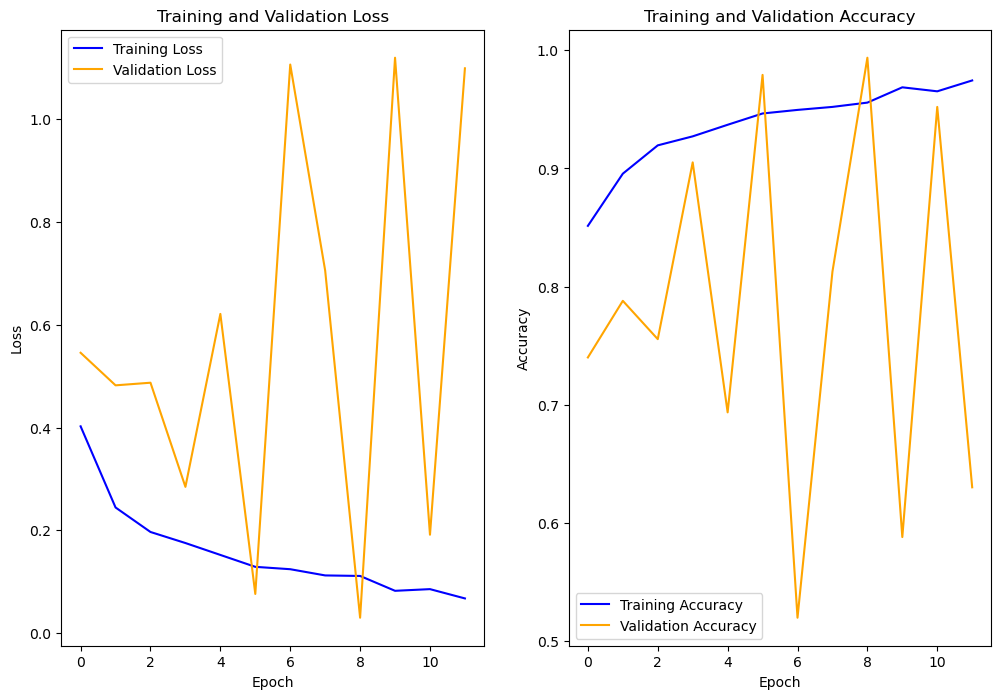

In [47]:
model_0a_plots = plot_learning_curve(history_model_0a)

Now I'll try the same but with SGD as the optimizer:

In [48]:
model_0b = Sequential(name="model_0b")
model_0b.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0b.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0b.add(MaxPool2D())
model_0b.add(BatchNormalization())
model_0b.add(Flatten())
model_0b.add(Dense(32, activation='relu'))
model_0b.add(Dense(1, activation='sigmoid'))

In [49]:
model_0b.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model_0b.summary()

Model: "model_0b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_10 (Flatten)        (None, 16384)             0         
                                                                 
 dense_20 (Dense)            (None, 32)                524

In [50]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0b = model_0b.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 20s 37ms/step - loss: 0.4664 - accuracy: 0.7763 - val_loss: 0.5933 - val_accuracy: 0.7870
Epoch 2/20
517/517 [==============================] - 20s 38ms/step - loss: 0.4056 - accuracy: 0.8237 - val_loss: 0.4452 - val_accuracy: 0.8398
Epoch 3/20
517/517 [==============================] - 20s 38ms/step - loss: 0.3798 - accuracy: 0.8409 - val_loss: 0.4467 - val_accuracy: 0.8374
Epoch 4/20
517/517 [==============================] - 23s 44ms/step - loss: 0.3475 - accuracy: 0.8570 - val_loss: 0.4473 - val_accuracy: 0.8369
Epoch 5/20
517/517 [==============================] - 20s 38ms/step - loss: 0.3229 - accuracy: 0.8724 - val_loss: 0.4228 - val_accuracy: 0.8359
Epoch 6/20
517/517 [==============================] - 23s 44ms/step - loss: 0.2938 - accuracy: 0.8808 - val_loss: 0.3861 - val_accuracy: 0.8635
Epoch 7/20
517/517 [==============================] - 24s 46ms/step - loss: 0.2817 - accuracy: 0.8880 - val_loss: 0.3585 - val_accuracy:

So the simple model does noticeably worse with the SGD optimizer. 

In [59]:
models = [model_1, model_2, model_2a, model_3, model_4, model_4a, 
             model_5, model_5a, model_0, model_0a, model_0b]
histories = [history_model_1, history_model_2, history_model_2a, history_model_3, history_model_4, history_model_4a, 
             history_model_5, history_model_5a, history_model_0, history_model_0a, history_model_0b]
print("Maximum validation accuracy achieved in for each model:")
for mod, hist in zip(models,histories):
    print(mod.name, round(max(hist.history['val_accuracy']),3))

Maximum validation accuracy achieved in for each model:
model_1 0.992
model_2 0.985
model_2a 0.991
model_3 0.975
model_4 0.994
model_4a 0.992
model_5 0.963
model_5a 0.977
model_0 0.96
model_0a 0.994
model_0b 0.946


So after reviewing these results, models 1,4,4a, and 0a have the highest validation accuracies, but these all have very volatile learning curves. The highest accuracy model with a relatively smooth learning curve is model 2 (which is also the best model with the larger validation set size). However, model 2 achieved its best validation accuracy on the 3rd epoch and only trained for 6 total epochs. Let's repeat training on model 2 below and allow it to go for 10-15 epcohs to see what the results look like:

In [60]:
model_2b = Sequential(name="model_2a")
model_2b.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2b.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2b.add(MaxPool2D())
model_2b.add(BatchNormalization())
model_2b.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2b.add(MaxPool2D())
model_2b.add(BatchNormalization())
model_2b.add(Flatten())
model_2b.add(Dense(64, activation='relu'))
model_2b.add(Dense(1, activation='sigmoid'))

model_2b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), 
                loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
start = time()

# Fit the model
history_model_2b = model_2b.fit(training, validation_data=test, epochs=12)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/12
517/517 [==============================] - 34s 64ms/step - loss: 0.3173 - accuracy: 0.8776 - val_loss: 3.0080 - val_accuracy: 0.0808
Epoch 2/12
517/517 [==============================] - 32s 62ms/step - loss: 0.1721 - accuracy: 0.9300 - val_loss: 0.0996 - val_accuracy: 0.9656
Epoch 3/12
517/517 [==============================] - 31s 61ms/step - loss: 0.1203 - accuracy: 0.9515 - val_loss: 0.3715 - val_accuracy: 0.8669
Epoch 4/12
517/517 [==============================] - 30s 58ms/step - loss: 0.1221 - accuracy: 0.9516 - val_loss: 2.1960 - val_accuracy: 0.4748
Epoch 5/12
517/517 [==============================] - 30s 58ms/step - loss: 0.0948 - accuracy: 0.9642 - val_loss: 0.0366 - val_accuracy: 0.9869
Epoch 6/12
517/517 [==============================] - 30s 58ms/step - loss: 0.0875 - accuracy: 0.9667 - val_loss: 0.0667 - val_accuracy: 0.9792
Epoch 7/12
517/517 [==============================] - 30s 58ms/step - loss: 0.0801 - accuracy: 0.9712 - val_loss: 0.0480 - val_accuracy:

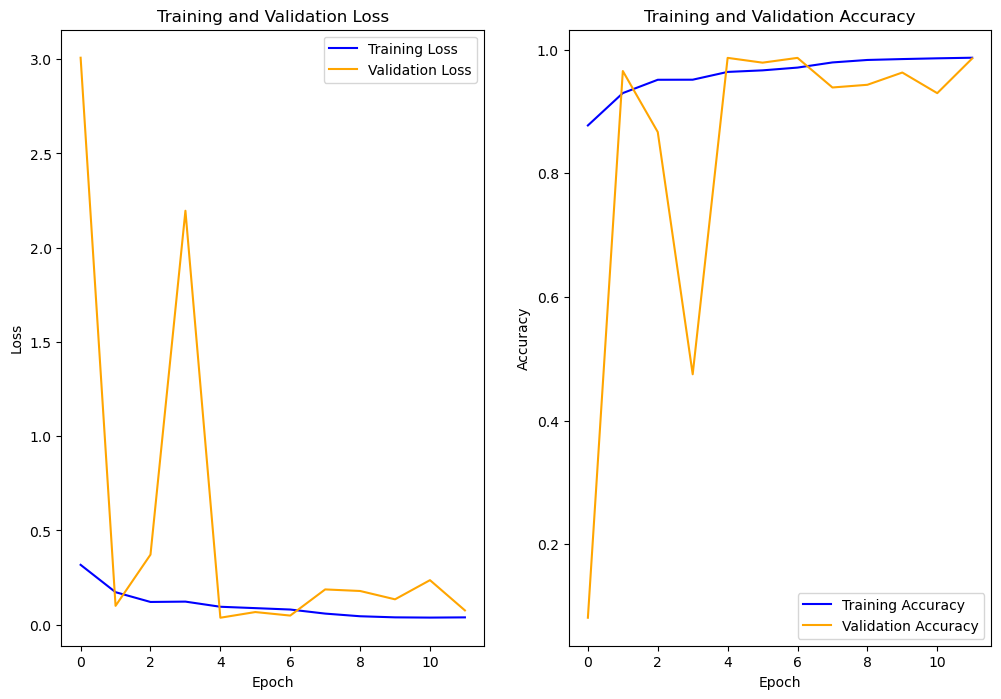

In [62]:
model_2b_plots = plot_learning_curve(history_model_2b)

Hmm, curiously, after allowing the model to run for more epochs, there is volatility present in the early epochs thart was not present when early stopping was implemented...
Nonetheless, with the best model architecture selected, I will try image augmentation preprocessing to see how that affects the model:

In [63]:
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                     layers.RandomRotation(0.1),])

In [65]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #to suppress to verbose warnings

augmented_training_ds = training.map(lambda img, label: (image_augmentation(img), label))

In [67]:
#model 2 with augmented training set
model_2_aug = Sequential(name="model_2_with_augmented_training_set")
model_2_aug.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2_aug.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2_aug.add(MaxPool2D())
model_2_aug.add(BatchNormalization())
model_2_aug.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2_aug.add(MaxPool2D())
model_2_aug.add(BatchNormalization())
model_2_aug.add(Flatten())
model_2_aug.add(Dense(64, activation='relu'))
model_2_aug.add(Dense(1, activation='sigmoid'))

model_2_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), 
                loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
start = time()

# Fit the model
history_model_2_aug = model_2_aug.fit(augmented_training_ds, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 38s 71ms/step - loss: 0.3340 - accuracy: 0.8693 - val_loss: 1.1657 - val_accuracy: 0.2957
Epoch 2/20
517/517 [==============================] - 35s 68ms/step - loss: 0.2108 - accuracy: 0.9185 - val_loss: 1.1556 - val_accuracy: 0.6912
Epoch 3/20
517/517 [==============================] - 43s 82ms/step - loss: 0.1808 - accuracy: 0.9262 - val_loss: 0.2602 - val_accuracy: 0.9192
Epoch 4/20
517/517 [==============================] - 36s 69ms/step - loss: 0.1527 - accuracy: 0.9428 - val_loss: 0.0914 - val_accuracy: 0.9753
Epoch 5/20
517/517 [==============================] - 37s 71ms/step - loss: 0.1233 - accuracy: 0.9527 - val_loss: 0.3647 - val_accuracy: 0.8969
Epoch 6/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1242 - accuracy: 0.9543 - val_loss: 0.6929 - val_accuracy: 0.8083
Epoch 7/20
517/517 [==============================] - 38s 74ms/step - loss: 0.1199 - accuracy: 0.9548 - val_loss: 0.2024 - val_accuracy:

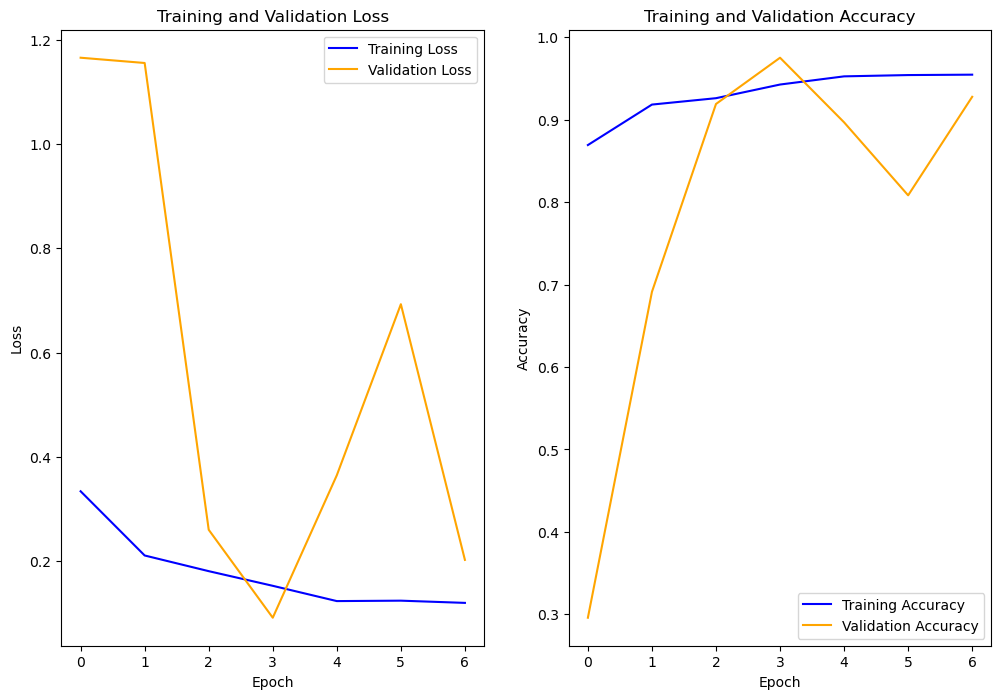

In [69]:
model_2_aug_plots = plot_learning_curve(history_model_2_aug)

As with the larger validation set, image augmentation actually reduced model performance based on both training and validation accuracy.